<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading  the data
from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("Shape of features:", X.shape)
print("Class distribution:")
print(y.value_counts())

Shape of features: (569, 30)
Class distribution:
target
1    357
0    212
Name: count, dtype: int64


In [6]:
# Data Preprocessing Steps
# Handling Missing Values & Duplicates
print(X.isnull().sum().sum())  # Check for missing values
print(X.duplicated().sum())    # Check for duplicates

# Encoding Categorical Features
# This dataset already numeric features

# Feature Scaling- Used StandardScaler to normalize numeric for distance-based algorithms
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split- Splittin the data into training and testing sets (80/20) with preserve class
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)



0
0
Training size: (455, 30)
Testing size: (114, 30)


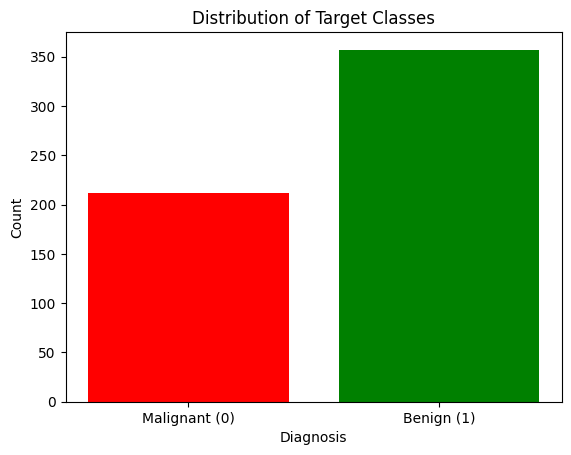

worst concave points   -0.793566
worst perimeter        -0.782914
mean concave points    -0.776614
worst radius           -0.776454
mean perimeter         -0.742636
worst area             -0.733825
mean radius            -0.730029
mean area              -0.708984
mean concavity         -0.696360
worst concavity        -0.659610
Name: correlation, dtype: float64


In [12]:
# Exploratory Data Analysis (EDA)
# Class Distribution
import matplotlib.pyplot as plt

# Visualize class counts
plt.bar(['Malignant (0)', 'Benign (1)'], y.value_counts().sort_index(), color=['red', 'green'])
plt.title('Distribution of Target Classes')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Summary Statistics
X.describe().T.head(10)

# Correlation Analysis
import pandas as pd

corr_with_target = pd.Series(X.corrwith(y), name='correlation').sort_values(key=abs, ascending=False)
print(corr_with_target.head(10))



In [13]:
# Model Implementation and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
    if y_prob is not None:
        print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")


Logistic Regression
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1-score:  0.9861
ROC-AUC:   0.9954

Random Forest
Accuracy:  0.9561
Precision: 0.9589
Recall:    0.9722
F1-score:  0.9655
ROC-AUC:   0.9931

SVM
Accuracy:  0.9825
Precision: 0.9861
Recall:    0.9861
F1-score:  0.9861
ROC-AUC:   0.9950

KNN
Accuracy:  0.9649
Precision: 0.9595
Recall:    0.9861
F1-score:  0.9726
ROC-AUC:   0.9792


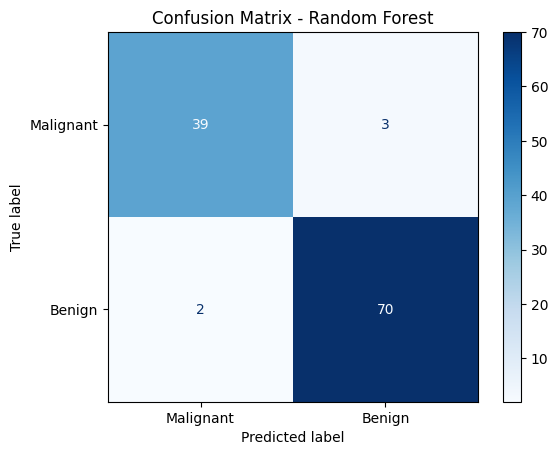

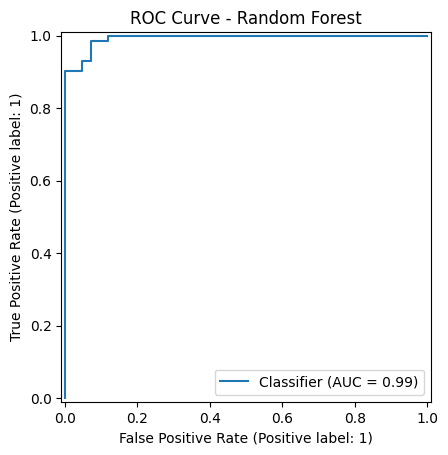

ROC-AUC Score: 0.9931


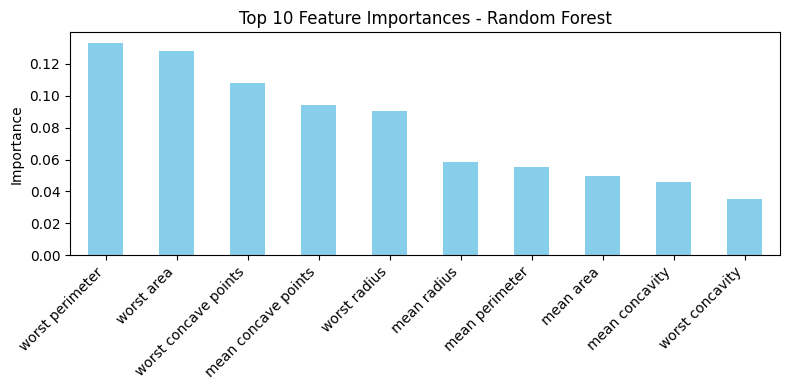

In [16]:
# Model Interpretation and Inference
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = models["Random Forest"]
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malignant', 'Benign'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve and AUC
from sklearn.metrics import RocCurveDisplay, roc_auc_score

y_prob = best_model.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Random Forest")
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Feature Importance
import pandas as pd

importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=data.feature_names).sort_values(ascending=False)

# Top 10 most important features
feat_imp.head(10).plot(kind='bar', figsize=(8,4), color='skyblue')
plt.title("Top 10 Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [18]:
# Deployment and Monitoring
# Export the Trained Model
import joblib

joblib.dump({'model': best_model, 'scaler': scaler}, 'best_model_pipeline.joblib')
print("✅ Model and scaler saved successfully!")

# Now create a REST API for Predictions
from fastapi import FastAPI
import joblib
import numpy as np

app = FastAPI()
bundle = joblib.load('best_model_pipeline.joblib')
model = bundle['model']
scaler = bundle['scaler']

@app.post('/predict')
def predict(features: list):
    X = np.array(features).reshape(1, -1)
    X_scaled = scaler.transform(X)
    pred = model.predict(X_scaled)[0]
    prob = model.predict_proba(X_scaled)[0][1]
    return {"prediction": int(pred), "probability": float(prob)}





✅ Model and scaler saved successfully!
